In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import tiktoken

### Building the Dataset

In [2]:
# Read the txt file to inspect it
with open('input.txt', 'r') as f:
    text = f.read()

print("Length of dataset:", len(text), "\n")
print(text[:100]) # First 100 characters

Length of dataset: 1115394 

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [3]:
chars = sorted(list(set(text))) # Get all unique characters in the text
vocab_size = len(chars)         # Length of the vocabulary (this includes the space character)
print(''.join(chars))
print(f'\nVocabulary size: {vocab_size}')


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz

Vocabulary size: 65


In [4]:
# This is both encoder and decoder
stoi = { ch:i for i,ch in enumerate(chars) }     # Character to index mapping
itos = { i:ch for i,ch in enumerate(chars) }     # Index to character mapping

encode = lambda s: [stoi[c] for c in s]          # Encode a string to a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # Decode a list of integers to a string

msg = "hii there"
token_list = encode(msg)
print(token_list)
print(decode(token_list))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


### Digression - Tiktoken

In [5]:
enc = tiktoken.get_encoding('gpt2')

msg = "hii there"
token_list = enc.encode(msg)
print(token_list) # BPE returns fewer tokens than the character encoding
print(enc.decode(enc.encode("hii there")))

print(enc.n_vocab) # total amount of tokens in the vocabulary

[71, 4178, 612]
hii there
50257


### Tokenizing the Dataset

In [6]:
# Encode the text into a tensor of integers
data = torch.tensor(encode(text), dtype=torch.long)
print(f'Total size: {data.shape} elements of type {data.dtype}')
print('First 10 tokens from the dataset:', data[:10])

Total size: torch.Size([1115394]) elements of type torch.int64
First 10 tokens from the dataset: tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47])


### Splitting the Dataset

In [7]:
n = int(0.9 * len(data)) # 90% of the data will be used for training and 10% for validation
train_data = data[:n]    # 0 to 90-th percentile
val_data = data[n:]      # 90-th percentile to the end

In [8]:
block_size = 8              # Upper limit on the length of the text sequences
train_data[:block_size + 1] # First 9 characters (8 + 1 for the target)

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [9]:
# first block of tokens
x = train_data[:block_size]    # e.g. [1, 2, 3, 4, 5, 6, 7, 8]
# individual tokens shifted by one (also including the very last token now)
y = train_data[1:block_size+1] # e.g. [2, 3, 4, 5, 6, 7, 8, 9]

for t in range(block_size):
    context = x[:t+1] # context means the prompt
    target = y[t]     # the token we want to predict
    print(f'When the prompt is {context}, predict {target}')

When the prompt is tensor([18]), predict 47
When the prompt is tensor([18, 47]), predict 56
When the prompt is tensor([18, 47, 56]), predict 57
When the prompt is tensor([18, 47, 56, 57]), predict 58
When the prompt is tensor([18, 47, 56, 57, 58]), predict 1
When the prompt is tensor([18, 47, 56, 57, 58,  1]), predict 15
When the prompt is tensor([18, 47, 56, 57, 58,  1, 15]), predict 47
When the prompt is tensor([18, 47, 56, 57, 58,  1, 15, 47]), predict 58


In [10]:
torch.manual_seed(1337)
batch_size = 4  # number of sequences in a batch / processed in parallel
block_size = 8  # maximum length of the sequence serving as a prompt/context

In [11]:
def get_batch(split, batch_size):
    # Generate a batch of inputs/prompts x and respective targets y
    # batches are always of shape (batch_size, block_size)
    data = train_data if split == 'train' else val_data
    # Tensor of shape (batch_size,) with random sequence start indices between 0 and len(data) - block_size
    ix = torch.randint(len(data) - block_size, (batch_size,))
    # Accumulate and add each sequence of this batch to form a tensor
    x = torch.stack([data[i:i+block_size] for i in ix])
    # Same as x but shifted by one token
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y # x is (4,8), y is (4,8) too

# Get a batch of inputs and targets
xb, yb = get_batch('train', batch_size)

# Print the shape of the batch and the actual data
print('inputs shape: ', xb.shape)
print(xb,'\n')
print('targets shape: ', yb.shape)
print(yb, '\n')

# Print the first batch
for b in range(batch_size):     # batch dimension, number of sequences in the batch (batch_size)
    for t in range(block_size): # time dimension, number of tokens in the sequence  (block_size)
        context = xb[b, :t+1]   # context means prompt, taking the first t+1 tokens from the b-th sequence in the batch
        target = yb[b, t]       # we take the t-th token from the b-th sequence in the batch for the target (the token we want to predict)
        print(f'When the prompt is {context}, predict {target}')
        # This context <-> target pair is what we feed to the model, it's variable in length

inputs shape:  torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]]) 

targets shape:  torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]]) 

When the prompt is tensor([24]), predict 43
When the prompt is tensor([24, 43]), predict 58
When the prompt is tensor([24, 43, 58]), predict 5
When the prompt is tensor([24, 43, 58,  5]), predict 57
When the prompt is tensor([24, 43, 58,  5, 57]), predict 1
When the prompt is tensor([24, 43, 58,  5, 57,  1]), predict 46
When the prompt is tensor([24, 43, 58,  5, 57,  1, 46]), predict 43
When the prompt is tensor([24, 43, 58,  5, 57,  1, 46, 43]), predict 39
When the prompt is tensor([44]), predict 53
When the prompt is tensor([44, 53]), predict 56
When the prompt is tensor([44, 53, 

### Embedding Layer

In [12]:
torch.manual_seed(1337) # for reproducibility

# Not really an LM at this stage, but we will get there...
class BigramLM(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # Embedding the vocabulary
        # Every one of the vocab_size tokens is represented by a vector of size vocab_size
        self.embed = nn.Embedding(vocab_size, vocab_size) # 65 unique 65-dim vectors

    def forward(self, idx, targets):
        # idx is of shape (batch_size, block_size)
        # targets is of shape (batch_size, block_size)
        # Embed the input indices, shape is now (batch_size, block_size, vocab_size) (B, T, C)
        logits = self.embed(idx)
        return logits


print('Vocabulary size:', vocab_size)  # Length of the vocabulary list (this includes the space character)
m = BigramLM(vocab_size)  # Instantiate the model
out = m(xb, yb)           # Forward pass (yb remains unused for now)
print(out.shape)          # (batch_size, block_size, vocab_size) -> 4 times 8 characters, each embedded as a 65-dim vector

Vocabulary size: 65
torch.Size([4, 8, 65])


### Setting up a Loss Function

In [13]:
torch.manual_seed(1337)

class BigramLM(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, vocab_size)  # Embedding the vocabulary, each individual token is represented by a vector of size vocab_size

    def forward(self, idx, targets):
        logits = self.embed(idx)      # Embed the input indices, shape is now (batch_size, block_size, vocab_size) (B, T, C)
        B, T, C = logits.shape        # B = batch_size, T = block_size, C = vocab_size
        logits = logits.view(B*T, C)  # Transpose logits to (B*T, C)
        # This is the first time we actively use the targets:
        targets = targets.view(B*T)   # Transpose targets to (B*T) (targets contains the next token's index for each input sequence in the batch)
        loss = F.cross_entropy(logits, targets)  # Calculating cross entropy loss across all tokens in the batch (using targets to plug out the correct token for each input sequence)
        return logits, loss


m = BigramLM(vocab_size)  # Instantiate the model
logits, loss = m(xb, yb)  # Forward pass (xb becomes embedded, yb is used to calculate the loss)
print(logits.shape)       # (batch_size * block_size, vocab_size)
print(loss.item())        # Loss value

torch.Size([32, 65])
4.878634929656982


In [14]:
torch.manual_seed(1337)

class BigramLM(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, vocab_size)      # Embedding the vocabulary, each individual token is represented by a vector of size vocab_size

    def forward(self, idx, targets=None):
        logits = self.embed(idx)                               # Embed the input indices, shape is now (batch_size, block_size, vocab_size) (B, T, C)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)                       # Transpose logits to (B, C, T) (B=batch_size, T=block_size, C=vocab_size)
            targets = targets.view(B*T)                        # Transpose targets to (B, T)
            loss = F.cross_entropy(logits, targets)            # Calculating cross entropy loss across all tokens in the batch
        return logits, loss

    # Generate new tokens based on respective last token of a sequence
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, _ = self(idx)                              # Forward pass (this is the forward function) with the current sequence of characters idx, results in (B, T, C)
            logits = logits[:, -1, :]                          # Focus on the last token from the logits (B, T, C) -> (B, C)
            probs = F.softmax(logits, dim=-1)                  # Calculate the probability distribution for the next token based on this last token, results in (B, C)
            idx_next = torch.multinomial(probs, num_samples=1) # Sample the next token (B, 1), the token with the highest probability is sampled most likely
            idx = torch.cat((idx, idx_next), dim=1)            # Add the new token to the sequence (B, T+1) for the next iteration
        return idx                                             # Return the sequence of tokens (B, T+1), these are characters

m = BigramLM(vocab_size)  # Instantiate the model
logits, loss = m(xb, yb)  # Forward pass

print(logits.shape)       # (batch_size, block_size, vocab_size)
print(loss) # Loss value

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)


### Producing The First Text

In [15]:
ix = torch.zeros((1, 1), dtype=torch.long)  # Start with a single tensor of shape (1, 1) holding a 0 (new line)
tokens = m.generate(ix, max_new_tokens=100) # Generate 100 tokens as a sequence of indices
print(tokens.shape)                         # Print the shape of the resulting sequence of tokens
print(decode(tokens[0].tolist()))           # Decode the resulting sequence of indices to a string

torch.Size([1, 101])

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


In [16]:
# Create a PyTorch Optimizer
# Instantiate AdamW optimizer with the model parameters (weights) 
# and a learning rate of 0.001 (often used value for *small* networks)
opt = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [17]:
batch_size = 32 # Increasing the batch size from 4 to 32
losses = []

# Train for 10000 steps/batches
for steps in range(10000):
    xb, yb = get_batch('train', batch_size) # Sample a batch of data
    logits, loss = m(xb, yb)                # Forward pass, calculate the loss
    loss.backward()                         # Backprop with PyTorch's autograd 
                                            # (effectively just updating the logits/the embedding vectors)
    opt.step()                              # Update the weights
    opt.zero_grad()                         # Set the gradients to zero

    # Print the loss every 100 steps
    if steps % 100 == 0:
        print(f'Loss at step {steps}: {loss.item()}')
        losses.append(loss.item())

Loss at step 0: 4.704006195068359
Loss at step 100: 4.658433437347412
Loss at step 200: 4.470171928405762
Loss at step 300: 4.320702075958252
Loss at step 400: 4.252743721008301
Loss at step 500: 4.241008758544922
Loss at step 600: 4.161406517028809
Loss at step 700: 4.044336795806885
Loss at step 800: 4.091874122619629
Loss at step 900: 3.7458465099334717
Loss at step 1000: 3.7031264305114746
Loss at step 1100: 3.7115283012390137
Loss at step 1200: 3.6330997943878174
Loss at step 1300: 3.422212600708008
Loss at step 1400: 3.4295449256896973
Loss at step 1500: 3.4233598709106445
Loss at step 1600: 3.3018524646759033
Loss at step 1700: 3.283510446548462
Loss at step 1800: 3.188281774520874
Loss at step 1900: 3.2000553607940674
Loss at step 2000: 3.1371781826019287
Loss at step 2100: 3.0028276443481445
Loss at step 2200: 3.058077812194824
Loss at step 2300: 2.958632707595825
Loss at step 2400: 2.9813663959503174
Loss at step 2500: 2.9196817874908447
Loss at step 2600: 2.8414011001586914


In [18]:
print(decode(m.generate(torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


Iyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henoure wounonthioneir thondy, y heltieiengerofo'dsssit ey
KIN d pe wither vouprrouthercc.
hathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so it t jod weancotha:
h hay.JUCle n prids, r loncave w hollular s O:
HIs; ht anjx?

DUThinqunt.

LaZAnde.
athave l.
KEONH:
ARThanco be y,-hedarwnoddy scace, tridesar, wnl'shenous s ls, theresseys
PlorseelapinghiybHen yof GLUCEN t l-t E:
I hisgothers je are!-e!
QLYotouciullle'z


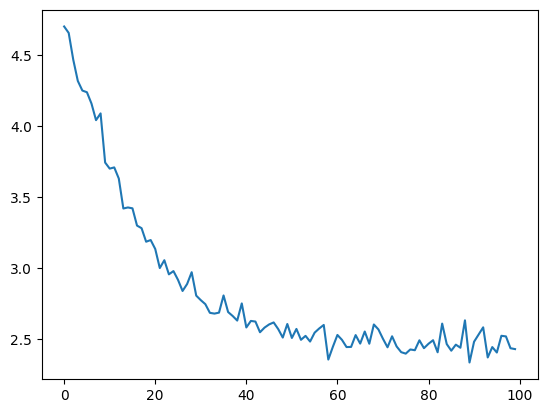

In [19]:
from matplotlib import pyplot as plt
plt.plot(losses);

In [20]:
eval_iters = 200
max_iters = 10000
eval_interval = 500

@torch.no_grad() # Disable gradient calculation for this function
def evaluate_loss():
    out = {}
    m.eval() # Set model to evaluation mode
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, batch_size)
            _, loss = m(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    m.train() # Set model back to training mode
    return out

train_losses = []

# Training
for iter in range(max_iters):
    xb, yb = get_batch('train', batch_size) # Get batch
    logits, loss = m(xb, yb)                # Forward pass
    loss.backward()                         # Backward pass
    opt.step()                        # Update parameters
    opt.zero_grad(set_to_none=True)   # Reset gradients

    if iter % eval_interval == 0:
        losses = evaluate_loss()
        train_losses.append(losses["train"].item())
        print(f'Iter {iter:4d} | Train Loss {losses["train"]:6.4f} | Val Loss {losses["val"]:6.4f}')

# Generate text from the model
context = torch.zeros((1, 1), dtype=torch.long) # Start with a zero context
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

Iter    0 | Train Loss 2.4641 | Val Loss 2.4913
Iter  500 | Train Loss 2.4795 | Val Loss 2.4841
Iter 1000 | Train Loss 2.4736 | Val Loss 2.4765
Iter 1500 | Train Loss 2.4727 | Val Loss 2.4847
Iter 2000 | Train Loss 2.4597 | Val Loss 2.4865
Iter 2500 | Train Loss 2.4558 | Val Loss 2.4824
Iter 3000 | Train Loss 2.4712 | Val Loss 2.4832
Iter 3500 | Train Loss 2.4614 | Val Loss 2.4743
Iter 4000 | Train Loss 2.4654 | Val Loss 2.4816
Iter 4500 | Train Loss 2.4545 | Val Loss 2.4749
Iter 5000 | Train Loss 2.4641 | Val Loss 2.4772
Iter 5500 | Train Loss 2.4518 | Val Loss 2.4795
Iter 6000 | Train Loss 2.4569 | Val Loss 2.4809
Iter 6500 | Train Loss 2.4540 | Val Loss 2.4837
Iter 7000 | Train Loss 2.4464 | Val Loss 2.4752
Iter 7500 | Train Loss 2.4587 | Val Loss 2.4739
Iter 8000 | Train Loss 2.4590 | Val Loss 2.4771
Iter 8500 | Train Loss 2.4469 | Val Loss 2.4736
Iter 9000 | Train Loss 2.4513 | Val Loss 2.4772
Iter 9500 | Train Loss 2.4574 | Val Loss 2.4792

Anit stho aree.
YONIste t
RYBur s;

Tha

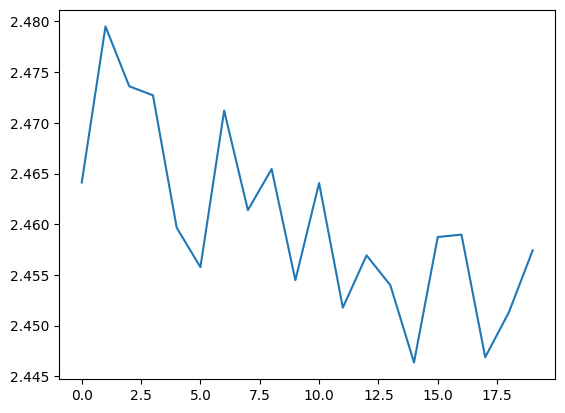

In [21]:
plt.plot(train_losses);

### The mathematical trick in self-attention

In [22]:
torch.manual_seed(1337)  # Set seed for reproducibility
B, T, C = 4, 8, 2        # Batch size, block size, vocab size
x = torch.randn(B, T, C) # Random numbers form a tensor of shape (B, T, C)

In [23]:
# We want x[b, t] = mean_{i <= t} x[b, i]
xbow = torch.zeros((B, T, C))          # Create tensor of zeros of shape (B, T, C) (bag of words representation of the input)
for b in range(B):                     # For all batches
    for t in range(T):                 # For all tokens in the batch
        xprev = x[b, :t+1]             # Get all tokens up to and including the current token (t, C)
        xbow[b, t] = xprev.mean(dim=0) # Calculate the mean of the tokens up to and including the current token

print('Batch [0]:\n', x[0], "\n")     # First batch of 8 tokens, each of size 2
print('Running Averages:\n', xbow[0]) # Running averages of the first batch of 8 tokens, each of size 2

Batch [0]:
 tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]]) 

Running Averages:
 tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])


In [24]:
# Consider the following example

torch.manual_seed(42)
a = torch.ones(3, 3)                        # 3x3 matrix of ones
b = torch.randint(0, 10, (3, 2)).float()    # 3x2 matrix of random integers between 0 and 9
c = a @ b                                   # Matrix multiplication of a and b
print(f'a (ones) =\n{a}\n')
print(f'b (random) =\n{b}\n')
print(f'c = a @ b =\n{c}\n')

a (ones) =
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

b (random) =
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])

c = a @ b =
tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])



In [25]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))   # Lower triangular matrix of ones
a = a / a.sum(dim=1, keepdim=True) # Normalize the matrix by dividing along each row
b = torch.randint(0, 10, (3, 2)).float() # 3x2 matrix of random integers between 0 and 9
c = a @ b                                # Matrix multiplication of a and b

print(f'a (ones + tril + avg) =\n{a}\n')
print(f'b (random) =\n{b}\n')
print(f'c = a @ b =\n{c}\n')

a (ones + tril + avg) =
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])

b (random) =
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])

c = a @ b =
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])



In [26]:
#Goal: We want x[b, t] to be mean_{i <= t} for x[b, i]
B, T, C = 4, 8, 2        # Batch size, block size, vocab size
x = torch.randn(B, T, C) # Random input of shape (B, T, C)

# Old:
xbow = torch.zeros((B, T, C))          # Create tensor of zeros of shape (B, T, C) (bag of words representation of the input)
for b in range(B):                     # For all batches
    for t in range(T):                 # For all tokens in the batch
        xprev = x[b, :t+1]             # Get all tokens up to and including the current token (t, C)
        xbow[b, t] = xprev.mean(dim=0) # Calculate the mean of the tokens up to and including the current token

# New:
wei = torch.tril(torch.ones(T, T))       # Lower triangular matrix of ones
wei = wei / wei.sum(dim=1, keepdim=True) # Normalizing wei by dividing by the sum of each row
xbow2 = wei @ x # (T, T) @ (B, T, C) -> PyTorch's Auto-Stride -> (B, T, T) @ (B, T, C) = (B, T, C)

torch.allclose(xbow, xbow2) # True

True

In [27]:
# New:
wei = torch.tril(torch.ones(T, T))       # Lower triangular matrix of ones
wei = wei / wei.sum(dim=1, keepdim=True) # Normalizing wei by dividing by the sum of each row
xbow2 = wei @ x                          # (T, T) @ (B, T, C) -> (B, T, T) @ (B, T, C) = (B, T, C)

# Newer:
tril = torch.tril(torch.ones(T, T))             # Lower triangular matrix of ones

wei = torch.zeros((T, T))                       # (T, T)
wei = wei.masked_fill(tril == 0, float('-inf')) # Masking all values in wei where tril == 0 with -inf
wei = F.softmax(wei, dim=-1)                    # (T, T)

xbow3 = wei @ x                                 # (T, T) @ (B, T, C) -> (B, T, T) @ (B, T, C) = (B, T, C)

torch.allclose(xbow2, xbow3)                     # True

True

In [28]:
exwei = torch.tensor([[0, 0, float('-inf'), float('-inf'), float('-inf'), float('-inf'), float('-inf')], 
                      [0, 0, 0, float('-inf'), float('-inf'), float('-inf'), float('-inf')]])
exsof = F.softmax(exwei, dim=-1) # -1 means the last dimension
print(exsof)

tensor([[0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000]])


In [29]:
tril = torch.tril(torch.ones(T, T))             # Lower triangular matrix of ones
wei = torch.zeros((T, T))                       # (T, T)
wei = wei.masked_fill(tril == 0, float('-inf')) # Masking all values in wei where tril == 0 with -inf
wei = F.softmax(wei, dim=-1)                    # (T, T)
xbow3 = wei @ x                                 # (T, T) @ (B, T, C) -> (B, T, T) @ (B, T, C) = (B, T, C)

print(wei[0:3])

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


### Building Self-Attention

In [30]:
# Version 4: Self-Attention
torch.manual_seed(1337)

B, T, C = 4, 8, 32        # Batch size, block size, vocab size (each token is a vector of size 32)
x = torch.randn(B, T, C)  # Random input of shape (B, T, C)

head_size = 16
key = nn.Linear(C, head_size, bias=False)   # No bias so that solely fixed weight matrix multiplication is performed
query = nn.Linear(C, head_size, bias=False) # No bias so that solely fixed weight matrix multiplication is performed
value = nn.Linear(C, head_size, bias=False) # No bias so that solely fixed weight matrix multiplication is performed

k = key(x)   # (B, T, C) -> (B, T, head_size)
q = query(x) # (B, T, C) -> (B, T, head_size)

wei = q @ k.transpose(-2, -1)  # (B, T, head_size) @ (B, head_size, T) = (B, T, T) (T is the block_size)

tril = torch.tril(torch.ones(T, T))             # Lower triangular matrix of ones
#wei = torch.zeros((T, T))                      # (T, T)
wei = wei.masked_fill(tril == 0, float('-inf')) # Masking all values in wei where tril == 0 with -inf
wei = F.softmax(wei, dim=-1)                    # (T, T)
#out = wei @ x  # (T, T) @ (B, T, C) -> (B, T, T) @ (B, T, C) = (B, T, C)

v = value(x)   # (B, T, C) -> (B, T, head_size)
out = wei @ v  # (B, T, T) @ (B, T, head_size) = (B, T, head_size)

print(wei[0])

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)


In [31]:
k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)
wei = q @ k.transpose(-2, -1) * (head_size ** -0.5) # This is the scaled attention, avoiding exploding variance which would sharpen the softmax distributions (and thus make the attention more deterministic)

print(k.var().item().__format__('.4f'))   # The variance is like before
print(q.var().item().__format__('.4f'))   # The variance is like before
print(wei.var().item().__format__('.4f')) # The variance is now much smaller

1.0449
1.0700
1.0918


In [32]:
# Makemore 3's BatchNorm1d
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps                        # Epsilon set to PyTorch default, you may change it
    self.momentum = momentum              # Momemtum set to PyTorch default, you may change it
    self.training = True
    # Initialize Parameters (trained with backprop)
    # (bngain -> gamma, bnbias -> beta)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # Initialize Buffers 
    # (Trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # Forward-Pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # Batch mean
      xvar = x.var(0, keepdim=True)   # Batch variance
    else:
      xmean = self.running_mean # Using the running mean as basis
      xvar = self.running_var   # Using the running variance as basis
    
    # Normalize to unit variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta  # Apply batch gain and bias
    
    # Update the running buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    
    return self.out

  def parameters(self):
    return [self.gamma, self.beta] # return layer's tensors

torch.manual_seed(1337)
module = BatchNorm1d(100)
x = torch.randn(32, 100)           # Batch size 32, 100 features (100-dimensional vectors)
print(x[:,0].mean(), x[:,0].std()) # Old mean and standard deviation of the first feature across the batch (not 0 and 1)
x = module(x)                      # Forward pass
print(x[:,0].mean(), x[:,0].std()) # New mean and standard deviation of the first feature across the batch (should be 0 and 1)
print(x[:5,0])                     # See how the feature indicates the normalization feature-wise across the batch, not sample-wise across the features
print(x.shape)                     # Output shape should is the same as input shape

tensor(0.1392) tensor(0.8899)
tensor(7.4506e-09) tensor(1.0000)
tensor([ 0.0468, -0.1209, -0.1358,  0.6035, -0.0515])
torch.Size([32, 100])


In [33]:
# LayerNorm
class LayerNorm:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps                        # Epsilon set to PyTorch default, you may change it
    self.gamma = torch.ones(dim)          # Initialize gain
    self.beta = torch.zeros(dim)          # Initialize bias

  def __call__(self, x):
    # Forward-Pass
    xmean = x.mean(1, keepdim=True) # Sample mean (across the features)
    xvar = x.var(1, keepdim=True)   # Sample variance (across the features)
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalize x to unit variance
    self.out = self.gamma * xhat + self.beta         # Apply feature gain and bias

    return self.out

  def parameters(self):
    return [self.gamma, self.beta] # return layer's tensors

torch.manual_seed(1337)
module = LayerNorm(100)
x = torch.randn(32, 100)           # Batch size 32, 100 features (100-dimensional vectors)
print(x[0,:].mean(), x[0,:].std()) # Old mean and standard deviation of the first feature across the batch (not 0 and 1)
x = module(x)                      # Forward pass
print(x[0,:].mean(), x[0,:].std()) # New mean and standard deviation of the first feature across the batch (should be 0 and 1)
print(x[0,:5])                     # See how the features indicate the normalization sample-wise across the features, not feature-wise across the batch
print(x.shape)                     # Output shape should is the same as input shape

tensor(0.0409) tensor(1.0476)
tensor(-9.5367e-09) tensor(1.0000)
tensor([ 0.1335, -0.1059, -0.3824, -0.9127,  0.5583])
torch.Size([32, 100])
